# Missing data use case

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from raking.experimental import  DataBuilder , DualSolver, PrimalSolver

pd.set_option('mode.chained_assignment', None)

Load the data and get them at the right format.

In [2]:
observations = pd.read_csv('observations.csv')
margins = pd.read_csv('margins.csv')

observations['weights'] = np.where( \
    observations['value'].isna(), 0.0, 1.0)

margins['race'] = 0
margins['county'] = 0
margins = margins.loc[margins.cause!='_all']
margins.rename(columns={'value_agg_over_race_county': 'value'}, inplace=True)
margins['weights'] = np.inf

df = pd.concat([ \
    observations[['value', 'cause', 'race', 'county', 'weights']], \
    margins[['value', 'cause', 'race', 'county', 'weights']]])

Rake initial dataset.

In [3]:
data_builder = DataBuilder(
    dim_specs={'cause': '_all', 'race': 0, 'county': 0},
    value='value',
    weights='weights',
)
data = data_builder.build(df)

solver = DualSolver(distance='entropic', data=data)
soln = solver.solve()

/Users/ducela/Documents/Raking/ihmeuw-msca/raking/src/raking/experimental/data.py:231: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_i_to_j = pd.concat(


Compute the margins.

In [4]:
sum_over_cause = soln.groupby(['race', 'county']).agg({'soln': 'sum'}).reset_index()
sum_over_cause['cause'] = '_all'

sum_over_race = soln.groupby(['cause', 'county']).agg({'soln': 'sum'}).reset_index()
sum_over_race['race'] = 0

sum_over_cause_race = soln.groupby(['county']).agg({'soln': 'sum'}).reset_index()
sum_over_cause_race['cause'] = '_all'
sum_over_cause_race['race'] = 0

sum_over_race_county = soln.groupby(['cause']).agg({'soln': 'sum'}).reset_index()
sum_over_race_county['race'] = 0
sum_over_race_county['county'] = 0

result = pd.concat([soln, sum_over_cause, sum_over_race, sum_over_cause_race, sum_over_race_county]). \
    merge(df, how='inner', on=['cause', 'race', 'county'])

Check if the margins are respected.

In [5]:
np.allclose(result.loc[(result.race==0)&(result.county==0)].value.to_numpy(), \
            result.loc[(result.race==0)&(result.county==0)].soln.to_numpy())

True

Plot raked values as a function of initial observations

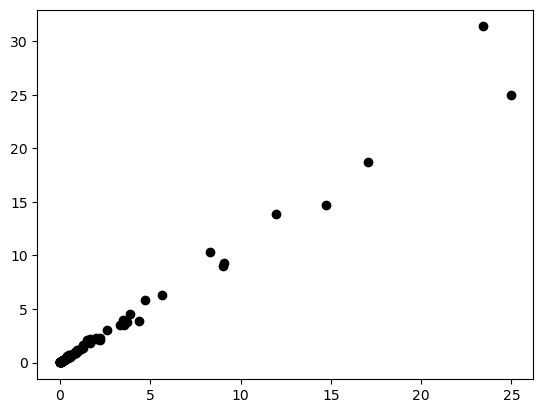

In [6]:
plt.plot(result.value.to_numpy(), result.soln.to_numpy(), 'ko')

Reproduce the bug in the code by adding one line with the aggregate missing value.

In [7]:
df2 = pd.concat([ \
    df, \
    pd.DataFrame({ \
        'value': [np.nan], \
        'cause': ['_all'], \
        'race': [3], \
        'county': [533], \
        'weights': [0.0]})])

In [8]:
data_builder = DataBuilder(
    dim_specs={'cause': '_all', 'race': 0, 'county': 0},
    value='value',
    weights='weights',
)
data2 = data_builder.build(df2)

solver2 = DualSolver(distance='entropic', data=data2)
soln2 = solver2.solve()

/Users/ducela/Documents/Raking/ihmeuw-msca/raking/src/raking/experimental/data.py:231: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_i_to_j = pd.concat(


ValueError: operands could not be broadcast together with shapes (93,) (92,) 

Look at the source of the error.

In [9]:
len(data2['span'])

60

In [10]:
len(data2['vec_w'])

92

In [11]:
data2['mat_c']

<Compressed Sparse Column sparse matrix of dtype 'int64'
	with 60 stored elements and shape (3, 60)>

In [12]:
solver2.mat_o

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 264 stored elements and shape (93, 39)>

In [13]:
data2['mat_mc1']

<Compressed Sparse Column sparse matrix of dtype 'int64'
	with 228 stored elements and shape (39, 57)>

In [14]:
df2.loc[df2.weights!=np.inf]

,value,cause,race,county,weights
0,4.715118,_all,0,531,1.0
1,2.577308,_comm,0,531,1.0
2,0.494816,_inj,0,531,1.0
3,1.684508,_ncd,0,531,1.0
4,1.006804,_all,1,531,1.0
...,...,...,...,...,...
91,0.869814,_all,7,534,1.0
92,0.402794,_comm,7,534,1.0
93,0.053793,_inj,7,534,1.0
94,0.359039,_ncd,7,534,1.0


In [15]:
df2.loc[(df2.weights>0)&(df2.weights!=np.inf)]

,value,cause,race,county,weights
0,4.715118,_all,0,531,1.0
1,2.577308,_comm,0,531,1.0
2,0.494816,_inj,0,531,1.0
3,1.684508,_ncd,0,531,1.0
4,1.006804,_all,1,531,1.0
...,...,...,...,...,...
90,0.631273,_ncd,4,534,1.0
91,0.869814,_all,7,534,1.0
92,0.402794,_comm,7,534,1.0
93,0.053793,_inj,7,534,1.0
